# Session 5 – Peak Fitting for Spectroscopy

This notebook demonstrates how to fit specific lineshapes to peaks in spectroscopic data. You will be introduced to Gaussian, Lorentzian and Voigt peak shapes and shown different methods for assessing goodness of fit.

Authors:
- Tom Slater

Email: slatert2@cardiff.ac.uk

## Learning objectives

By the end you will be able to:
- Generate and visualise Gaussian, Lorentzian and Voigt lineshapes (common to spectroscopic data).
- Quantify model–data mismatch with **root-mean-square (RMS) error**.
- Perform basic parameter estimation by **minimising RMS error**.
- Fit using scipy's **curve_fit()** and quantify the standard deviation on fit parameters.



## 0. Setup

Run the cell below to import the libraries used throughout. We will only use standard scientific Python packages. If `scipy` is available on your system, we'll also demonstrate how to use it, but it is **not required**.


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

NumPy: 2.2.5
SciPy available: True



## 1. Lineshape functions

In spectroscopy and diffraction, two ubiquitous peak shapes are the **Gaussian** and the **Lorentzian**. The definitions of these are:

- **Gaussian** (standard deviation `sigma`):  
  $G(x; A, x_0, \sigma) = A\, \exp\!\left(-\frac{(x-x_0)^2}{2\sigma^2}\right)$

- **Lorentzian** (half-width at half-maximum `gamma`):  
  $L(x; A, x_0, \gamma) = \frac{A\, \gamma^2}{(x-x_0)^2 + \gamma^2}$

Conventions vary: some definitions normalise the area to 1. Here we keep **amplitude `A`** as the peak height for both models (i.e. value at the centre `x_0`).

**Design choice:** We'll use the consistent parameter order `(x, A, x0, width)` where width is `sigma` for Gaussian and `gamma` for Lorentzian.


The following code demonstrates a function that defines a Gaussian:

In [ ]:
def gaussian(x, A, x0, sigma):
    """Return a Gaussian lineshape evaluated at x.

    Parameters
    ----------
    x : array_like
        Coordinates at which to evaluate the function.
    A : float
        Peak amplitude (height at the centre x0).
    x0 : float
        Peak centre.
    sigma : float
        Standard deviation (controls width).

    Returns
    -------
    ndarray
        G(x; A, x0, sigma).
    """
    x = np.asarray(x)
    return A * np.exp(-((x - x0) ** 2) / (2.0 * sigma ** 2))

<div class="alert alert-success">
<b>Task 1.1: Write a function called `lorentzian` that returns a numpy array containing a Lorentzian distribution. The function should have a readable docstring.<br></b>

</div>

In [14]:
#Input your answer to 1.1 here.
def lorentzian(x, A, x0, gamma):
    """Return a Lorentzian lineshape evaluated at x.

    Parameters
    ----------
    x : array_like
        Coordinates at which to evaluate the function.
    A : float
        Peak amplitude (height at the centre x0).
    x0 : float
        Peak centre.
    gamma : float
        Half-width at half-maximum (HWHM).

    Returns
    -------
    ndarray
        L(x; A, x0, gamma).
    """
    x = np.asarray(x)
    return (A * (gamma ** 2)) / ((x - x0) ** 2 + gamma ** 2)



### Quick check

Let's visualise both shapes for the same nominal parameters.

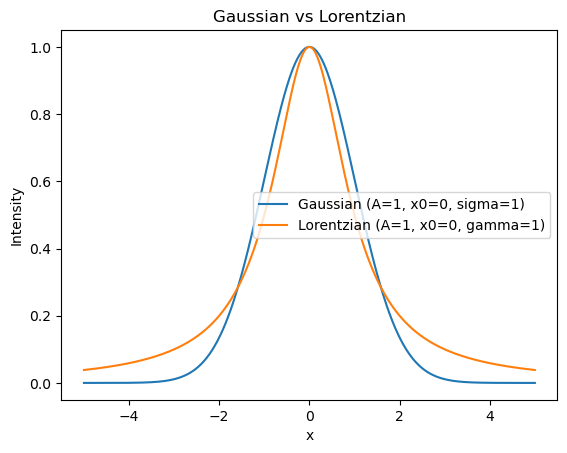

In [15]:
x = np.linspace(-5, 5, 501)

G = gaussian(x, A=1.0, x0=0.0, sigma=1.0)
L = lorentzian(x, A=1.0, x0=0.0, gamma=1.0)

plt.figure()
plt.plot(x, G, label="Gaussian (A=1, x0=0, sigma=1)")
plt.plot(x, L, label="Lorentzian (A=1, x0=0, gamma=1)")
plt.xlabel("x"); plt.ylabel("Intensity"); plt.legend(); plt.title("Gaussian vs Lorentzian")
plt.show()

## 2. Fitting lineshapes to data
There are many cases in chemistry in which we may obtain data and would like to fit a function to that data. In the case of the Gaussian and Lorentzian function above, fitting the functions allows us to determine the peak position, amplitude and width, which may give us important information on the structure of molecules and surfaces.

Fitting a function to data generally involves minimising the distance between the function and the data. One common method of defining the distance between two datasets is the **root-mean-square (RMS) error**.


### 2.1. RMS error between two datasets

Given two arrays of equal length, the **root-mean-square (RMS) error** is:

\$\mathrm{RMS}(y, \hat{y}) = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 }$

The code below defines a function for calculating the RMS between two datasets (y and yhat).


In [4]:
def rms_error(y, yhat):
    """Compute the root-mean-square error between y and yhat.

    Parameters
    ----------
    y : array_like
        Ground-truth or observed data.
    yhat : array_like
        Model predictions at the same x-values.

    Returns
    -------
    float
        RMS error.
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    if y.shape != yhat.shape:
        raise ValueError("y and yhat must have the same shape")
    return float(np.sqrt(np.mean((y - yhat) ** 2)))


<div class="alert alert-success">
<b>Task 2.1: Check that the code above returns a reasonable value for two identical datasets. Create two arrays where `y == yhat` and confirm the RMS error is 0. <br></b>

</div>

<div class="alert alert-success">
<b>Task 2.2: Create two arrays of the same length, but with different values, and calculate the RMS error between the two arrays. <br></b>
How has the RMS error changed from the previous task? 
</div>

### 2.2 Simulating experimental data
We'll now create a noisy single-peak dataset that imitates an experimental spectrum, so that we can practice fitting to some data.

The code below creates a Gaussian dataset and then add noise using the `np.random.default_rng()` function.

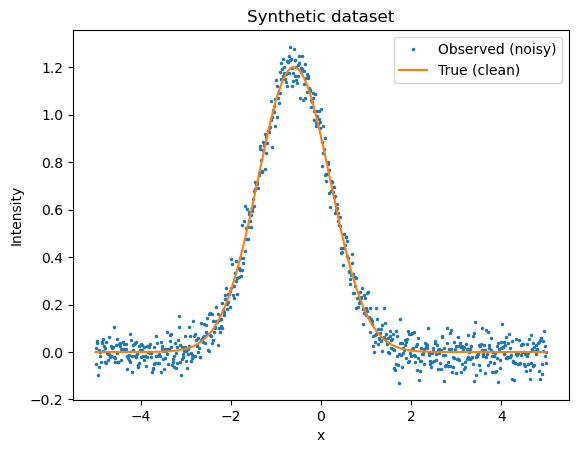

In [17]:

rng = np.random.default_rng(42)

# x-axis for our synthetic spectrum
x = np.linspace(-5, 5, 751)

# Ground-truth parameters
A_true   = 1.2
x0_true  = -0.6
w_true   = 0.8    # sigma if Gaussian, gamma if Lorentzian
noise_sd = 0.05

y_clean = gaussian(x, A_true, x0_true, w_true)

y_obs = y_clean + rng.normal(0.0, noise_sd, size=x.shape)

plt.figure()
plt.plot(x, y_obs, '.', ms=3, label='Observed (noisy)')
plt.plot(x, y_clean, label='True (clean)')
plt.xlabel("x"); plt.ylabel("Intensity"); plt.title("Synthetic dataset"); plt.legend()
plt.show()



## 2.3 Fit by minimising RMS error (grid search)

We will write a generic **grid-search** minimiser that explores a parameter space and returns the parameters that give the smallest RMS error. This is robust, dependency-free, and easy to understand, though not the fastest.

We'll fit both Gaussian and Lorentzian models to the same data and compare RMS errors.

Let's go through the process step-by-step to set this up.


Firstly, we'll need to define the limits of each parameter to search through and then calculate the RMS error for each value in our search range. We'll use an if statement to check if the RMS value is lower than the best value we have so far, and if it is we'll update the best RMS value and best parameters.

The example code below demonstrates this for a single parameter (A).

In [37]:
A_array = np.linspace(0.1, 2.0, 51)
x0 = -0.6
width = 0.8

best_rms = np.inf
best = None

for A in A_array:
    params = (A, x0, w)
    yhat = gaussian(x, A, x0, width)
    r = rms_error(y_obs, yhat)
    if r < best_rms:
        best_rms = r
        best = params

print("The best RMS value found is: " + str(best_rms) + " with parameters: " + str(best))

The best RMS value found is: 0.04921023089036489 with parameters: (np.float64(1.202), -0.6, np.float64(2.0))


<div class="alert alert-success">
<b>Task 2.3: Use a nested for loop to scan over parameters for A, x0 and width to fit a Gaussian to the y_obs data. Choose suitable ranges for each parameter, with 51 values in each range for each. Output the best RMS value as best_rms_gaussian and the best parameters as best_gaussian.<br></b>
How long does the search take? What happens to the time and the best fit parameters if you use only 21 points in the parameter search instead of 51?
</div>

In [ ]:
A_range  = (0.1, 2.0)
x0_range = (-2.5, 2.5)
w_range  = (0.1, 2.0)
As = np.linspace(*A_range, 51)
X0s = np.linspace(*x0_range, 51)
Ws = np.linspace(*w_range, 51)
best = None
best_rms = np.inf
for A in As:
    for x0 in X0s:
        for w in Ws:
            params = (A, x0, w)
            yhat = gaussian(x, A, x0, sigma=w)
            r = rms_error(y_obs, yhat)
            if r < best_rms:
                best_rms = r
                best = params
print(best_gaussian,best_rms_gaussian)

<div class="alert alert-success">
<b>Task 2.4: Repeat Task 2.3, but fit the best parameters for a Lorentzian function instead. Output the best RMS value as best_rms_lorentzian and the best parameters as best_lorentzian.<br></b>
</div>


### Visualise the fits


We know that the model data is Gaussian in shape, so the best fit should be from the Gaussian function. Let's visually check that by plotting the two fitted functions with the y_obs data.

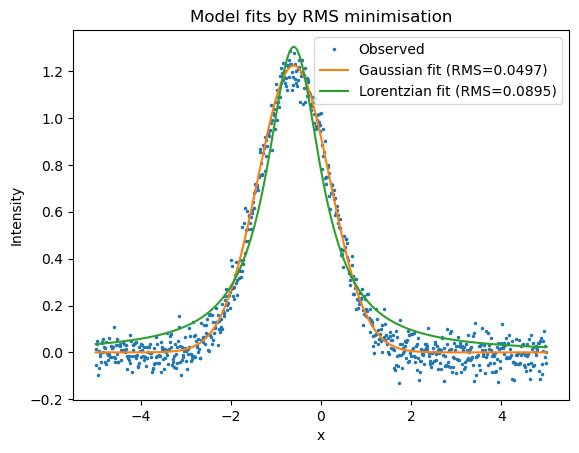

In [8]:
plt.figure()
plt.plot(x, y_obs, '.', ms=3, label='Observed')
plt.plot(x, gaussian(best_gaussian[0],best_gaussian[1],best_gaussian[2]), label=f'Gaussian fit (RMS={best_rms_gaussian:.4f})')
plt.plot(x, gaussian(best_lorentzian[0],best_lorentzian[1],best_lorentzian[2]), label=f'Lorentzian fit (RMS={best_rms_lorentzian:.4f})')
plt.xlabel("x"); plt.ylabel("Intensity"); plt.title("Model fits by RMS minimisation"); plt.legend()
plt.show()


## 3. Voigt profiles
The Gaussian and Lorentzian lineshapes used so far fit to many different types of data. However, there are many types of spectroscopy in which lineshapes become a little more complicated.

For instance, the peak below is typical of the lineshape of peak found in X-ray photoelectron spectroscopy (XPS). If we try to fit a Gaussian or Lorentzian to this peak, we can visually see the fit is not quite right.



In XPS (and many other types of spectroscopy), peaks take a shape known as a Voigt profile, which is a convolution of a Gaussian and Lorentzian function. This shape often arises due to combinations of Gaussian and Lorentzian peak broadening processes.

Thankfully, rather than having to code a convolution of two functions, scipy provides us with a function to generate a Voigt profile. The `voigt_profile()` function takes 3 arguments: the array of x values, the sigma of the Gaussian distribution and the gamma of the Lorentzian distribution.

In [39]:
from scipy.special import voigt_profile

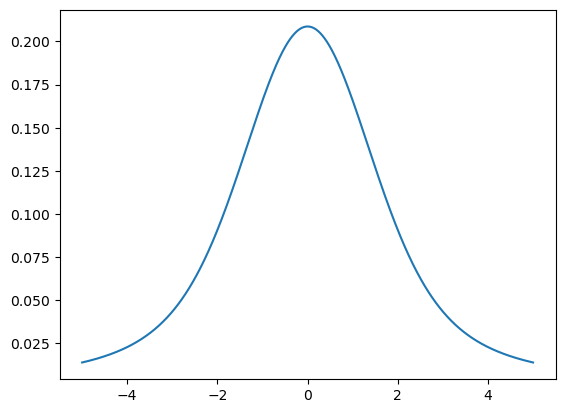

In [42]:
y_voigt = voigt_profile(x, 1.0, 1.0)

plt.figure()
plt.plot(x, y_voigt)
plt.show()

The example above had both sigma and gamma equal to 1. By changing the relative values, you can change the weighting of the Gaussian and Lorentzian components. Setting either sigma or gamma to 0 results in a profile that is equal to a pure Lorentzian or Gaussian distribution, respectively.

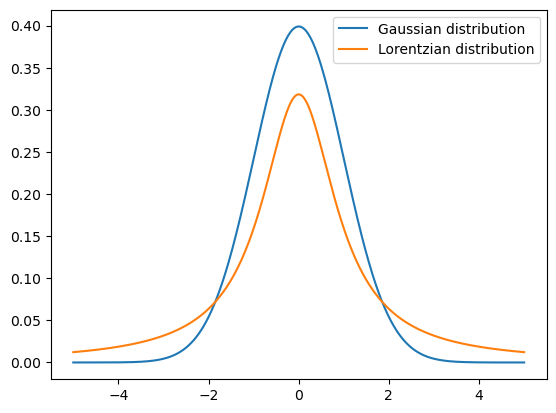

In [44]:
y_gauss = voigt_profile(x, 1.0, 0)
y_lorentz = voigt_profile(x, 0, 1.0)
plt.figure()
plt.plot(x, y_gauss, label='Gaussian distribution')
plt.plot(x, y_lorentz, label='Lorentzian distribution')
plt.legend()
plt.show()

The `voigt_profile()` function does not have any way to change the amplitude or position of the peak. The distribution is normalised so that the intensity under the peak is equal to $\sqrt{\pi}$ and it is centred at zero. 

To specify an amplitude and position, it's necessary to multiply the Voigt profile by a value to define an amplitude, and subtract a value from x to specify a position. For example, to plot a Voigt profile with amplitude approximately 1 and a centre at 0.2:

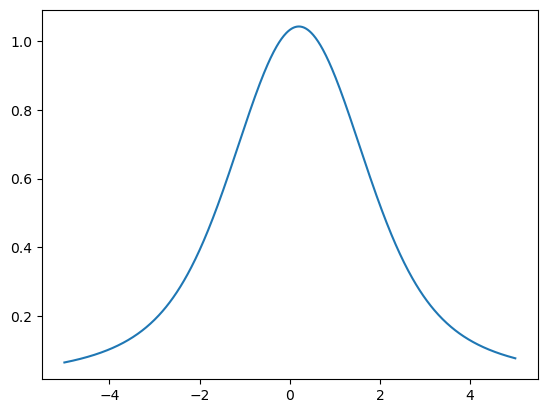

In [45]:
y_voigt = 5*voigt_profile(x-0.2, 1.0, 1.0)

plt.figure()
plt.plot(x, y_voigt)
plt.show()

<div class="alert alert-success">
<b>Task 3.1: Write a function called `shifted_voigt` that takes the arguments (x, amplitude, centre, sigma, gamma) and returns a Voigt profile with the ampltiude and centre specified in the arguments. <br></b>
</div>

In [47]:
def shifted_voigt(x, amplitude, center, sigma, gamma):
    """Shifted and scaled Voigt profile."""
    return amplitude * voigt_profile(x - center, sigma, gamma)

## 4. Fitting multi-peak models
If we consider XPS data further, it's very rare that datasets will contain a single peak. Typically, there will be two or more (sometimes overlapping) peaks in a spectrum.

Creating a model with two peaks is fairly simple. You can do this by just running a for loop and adding created Voigt profiles to a dataset.

For example, for 2 peaks with different centres and amplitudes:

1.0
2.0


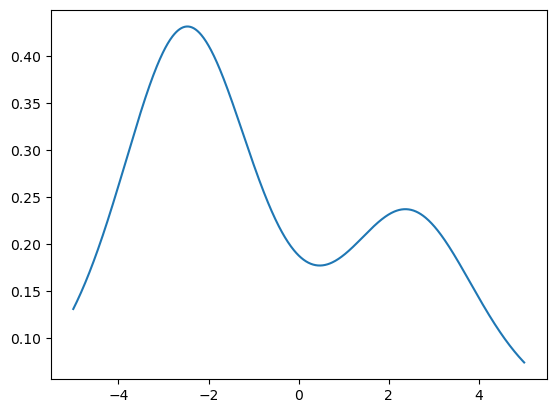

In [58]:
n_peaks = 2
params = [1.0, 2.5, 1.0, 1.0, 2.0, -2.5, 1.0, 1.0]

y = np.zeros_like(x)

for i in range(n_peaks):
    y += shifted_voigt(x, params[4*i],params[4*i+1], params[4*i+2], params[4*i+3])
    print(params[4*i])

plt.figure()
plt.plot(x, y)
plt.show()

<div class="alert alert-success">
<b>Task 4.1: Write a function called `multi_voigt` that takes the arguments (x, *params) and returns a profile with multiple Voigt peaks. <br></b>
Note: *params here specifies that multiple arguments could be passed as params, which will be combined into a tuple.
</div>

Hint: Think about how you would define n_peaks in your function based on the input params.

In [62]:
def multi_voigt(x, *params):
    """
    Sum of multiple Voigt peaks.
    params = [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2, ...]
    """
    n_peaks = len(params) // 4
    y = np.zeros_like(x)
    for i in range(n_peaks):
        A, x0, sigma, gamma = params[4*i:4*i+4]
        y += shifted_voigt(x, A, x0, sigma, gamma)
    return y

Now, let's try to fit two Voigt peaks to the data we've generated above, to recover our input values.

Previously, we fit lineshapes by minimising the RMS error in a nested for loop. If we tried that now, we'd have 8 nested for loops and the process would take a considerable amount of time!

Instead, we'll use a built-in scipy function called `curve_fit()`. The `curve_fit()` function takes the function to fit, the x values, the data and the parameters of the function as arguments, and returns two items:

- popt (the parameters associated with the optimal fit)
- pcov (the approximate covariance of the parameters)

Let's see an example:

In [60]:
from scipy.optimize import curve_fit

Best-fit parameters: [ 2.  -2.5  1.   1.   1.   2.5  1.   1. ]


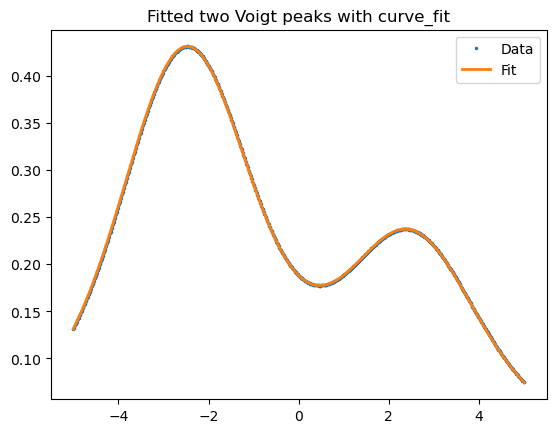

In [65]:
# Initial guess for [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2]
p0 = [1.0, -1.5, 1.0, 0.5,
      1.0, 2.5, 1.0, 0.5]

popt, pcov = curve_fit(multi_voigt, x, y, p0=p0)

print("Best-fit parameters:", popt)

y_fit = multi_voigt(x, *popt)

plt.plot(x, y, '.', ms=3, label="Data")
plt.plot(x, y_fit, '-', lw=2, label="Fit")
plt.legend(); plt.title("Fitted two Voigt peaks with curve_fit")
plt.show()

The fit above appears perfect, and we might expect that considering the fitted values match our initial values.

We can assess the goodness of fit in a number of ways.

Firstly, we can examine the covariance of parameters from `curve_fit()`.

In [66]:
print(pcov)

[[ 8.74759112e-32  9.05676120e-33 -8.75230954e-32  1.48102669e-31
  -6.27319135e-32  2.23668276e-32  5.76965492e-32 -1.30965399e-31]
 [ 9.05676120e-33  2.20572529e-33 -5.16702137e-33  1.07534105e-32
  -1.11834121e-32  2.94143833e-33  1.94562877e-32 -3.49151813e-32]
 [-8.75230954e-32 -5.16702137e-33  1.20555191e-31 -1.85384208e-31
   2.88482916e-32 -1.94562937e-32  4.79210282e-32 -3.09193171e-32]
 [ 1.48102669e-31  1.07534105e-32 -1.85384208e-31  2.94269966e-31
  -6.54827171e-32  3.49151885e-32 -3.09193308e-32 -2.60209458e-32]
 [-6.27319135e-32 -1.11834121e-32  2.88482916e-32 -6.54827171e-32
   8.74758875e-32 -1.81135218e-32 -1.75046113e-31  2.96205235e-31]
 [ 2.23668276e-32  2.94143833e-33 -1.94562937e-32  3.49151885e-32
  -1.81135218e-32  8.82290155e-33  2.06680789e-32 -4.30136355e-32]
 [ 5.76965492e-32  1.94562877e-32  4.79210282e-32 -3.09193308e-32
  -1.75046113e-31  2.06680789e-32  4.82220560e-31 -7.41536545e-31]
 [-1.30965399e-31 -3.49151813e-32 -3.09193171e-32 -2.60209458e-32
   

At first glance, the array of numbers in pcov are not that easy to interpret. As the pcov array contains covariances, the diagaonals should be the variance on each of the parameters. The standard deviation on each parameter can be calculated by taking the square root of the diagonal elements.

In [68]:
perr = np.sqrt(np.diag(pcov))
print(perr)

[2.95763269e-16 4.69651497e-17 3.47210586e-16 5.42466558e-16
 2.95763229e-16 9.39303016e-17 6.94421025e-16 1.08493294e-15]


The standard deviations on each parameter are very small relative to the parameter values as we'd expect!

We could also calculate the RMS error between the initial data and the fitted function to estimate goodness of fit, by using the RMS error function we defined previously.

In [70]:
print(rms_error(y, y_fit))

6.212736755513251e-17


The RMS error here is vanishingly small, as we'd expect here.

One final method for assessing goodness of fit is to visually inspect the residuals of the fit. The residuals are the difference between the observed and fitted data, and you can obtain them by simply subtracting the fitted data from the original data.

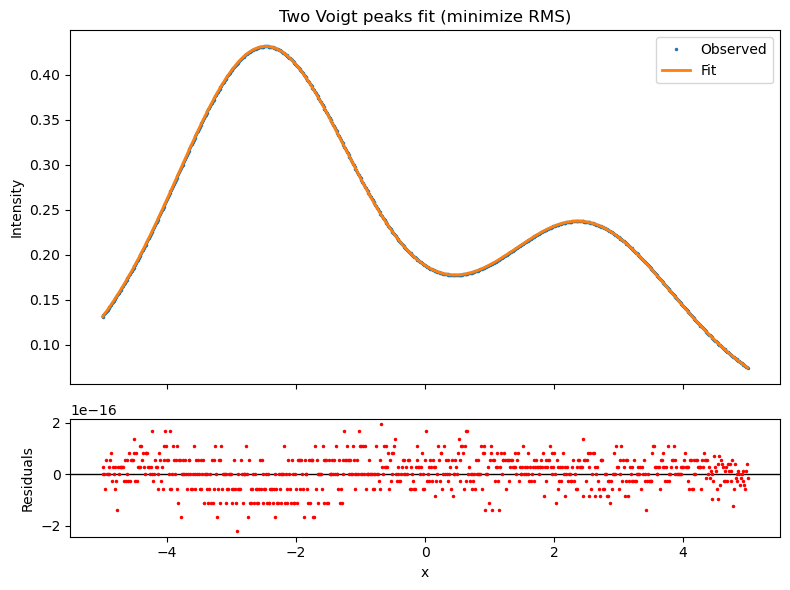

In [71]:
residuals = y - y_fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True,
                               gridspec_kw={'height_ratios':[3,1]})

# Top plot: data and fit
ax1.plot(x, y, '.', ms=3, label="Observed")
ax1.plot(x, y_fit, '-', lw=2, label="Fit")
ax1.legend()
ax1.set_ylabel("Intensity")
ax1.set_title("Two Voigt peaks fit (minimize RMS)")

# Bottom plot: residuals
ax2.axhline(0, color='k', lw=1)
ax2.plot(x, residuals, '.', ms=3, color="red")
ax2.set_xlabel("x")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

<div class="alert alert-success">
<b>Task 4.2: Attempt to fit 3 peaks to the y data obtained above, with appropriate initial guesses for all parameters. Plot the residual and calculate both the RMS error and the standard deviations on all parameters.<br></b>
How do the errors compare to the correct fitting of two peaks?
</div>
